In [1]:
from pathlib import Path
from tqdm import tqdm
from typing import *

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np


ROOT_DIR = Path(os.getcwd()).parent

In [2]:
df = pd.read_parquet(
    os.path.join(ROOT_DIR, "data/datasets/train_16_04.parquet")
)

df = df.reset_index(drop=True)

<h4>Preprocessing features for training dataset</h4>

In [3]:
df["pump_hash"] = df["pumped_ticker"] + df["pump_time"]

In [4]:
# create features
window_names: List[str] = ["1d", "7d", "14d", "30d"]

df_features: pd.DataFrame = df.copy()
df_features["pump_hash"] = df_features["pumped_ticker"] + "_" + df_features["pump_time"]

# Scale by std_30d
for window in window_names:
    df_features[f"log_returns_1h_mean_{window}_std_30d_ratio"] = (
        df[f"log_returns_1h_mean_{window}"] / df[f"log_returns_1h_std_30d"]
    )
# Scale by mean_30d
for col in ["num_trades_1h", "quote_abs_1h"]:
    for window in window_names:
        df_features[f"{col}_mean_{window}_std_30d_ratio"] = (
            df[f"{col}_mean_{window}"] / df[f"{col}_mean_30d"]
        )

df_features.head(1)

,imbalance_ratio_1d,imbalance_ratio_7d,imbalance_ratio_14d,imbalance_ratio_30d,log_returns_1h_mean_1d,log_returns_1h_std_1d,num_trades_1h_mean_1d,num_trades_1h_std_1d,quote_abs_1h_mean_1d,quote_abs_1h_std_1d,...,log_returns_1h_mean_14d_std_30d_ratio,log_returns_1h_mean_30d_std_30d_ratio,num_trades_1h_mean_1d_std_30d_ratio,num_trades_1h_mean_7d_std_30d_ratio,num_trades_1h_mean_14d_std_30d_ratio,num_trades_1h_mean_30d_std_30d_ratio,quote_abs_1h_mean_1d_std_30d_ratio,quote_abs_1h_mean_7d_std_30d_ratio,quote_abs_1h_mean_14d_std_30d_ratio,quote_abs_1h_mean_30d_std_30d_ratio
0,-0.137987,-0.140755,-0.129078,-0.154305,0.000487,0.012391,45.32,32.623764,1.10085,0.851101,...,-0.004172,-0.056472,0.571387,0.734612,0.894857,1.0,0.587729,0.75438,0.921812,1.0


In [5]:
std_cols = [
    "log_returns_1h_std_1d",
    "num_trades_1h_std_1d",
    "quote_abs_1h_std_1d",
    "log_returns_1h_std_7d",
    "num_trades_1h_std_7d",
    "quote_abs_1h_std_7d",
    "log_returns_1h_std_14d",
    "num_trades_1h_std_14d",
    "quote_abs_1h_std_14d",
    "log_returns_1h_std_30d",
    "num_trades_1h_std_30d",
    "quote_abs_1h_std_30d",
]

mean_cols = [
    "log_returns_1h_mean_1d",
    "num_trades_1h_mean_1d",
    "quote_abs_1h_mean_1d",
    "log_returns_1h_mean_7d",
    "num_trades_1h_mean_7d",
    "quote_abs_1h_mean_7d",
    "log_returns_1h_mean_14d",
    "num_trades_1h_mean_14d",
    "quote_abs_1h_mean_14d",
    "log_returns_1h_mean_30d",
    "num_trades_1h_mean_30d",
    "quote_abs_1h_mean_30d",
]

scaled_cols = [
    # Standardized by std_30d
    "log_returns_1h_mean_1d_std_30d_ratio",
    "log_returns_1h_mean_7d_std_30d_ratio",
    "log_returns_1h_mean_14d_std_30d_ratio",
    "log_returns_1h_mean_30d_std_30d_ratio",
    "num_trades_1h_mean_1d_std_30d_ratio",
    "num_trades_1h_mean_7d_std_30d_ratio",
    "num_trades_1h_mean_14d_std_30d_ratio",
    # "num_trades_1h_mean_30d_std_30d_ratio",
    "quote_abs_1h_mean_1d_std_30d_ratio",
    "quote_abs_1h_mean_7d_std_30d_ratio",
    "quote_abs_1h_mean_14d_std_30d_ratio",
    # "quote_abs_1h_mean_30d_std_30d_ratio",
]

exchange_vol_cols = [
    'daily_exchange_vol_ratio_1d_mean',
    'daily_exchange_vol_ratio_7d_mean', 'daily_exchange_vol_ratio_7d_std',
    'daily_exchange_vol_ratio_14d_mean', 'daily_exchange_vol_ratio_14d_std',
    'daily_exchange_vol_ratio_30d_mean', 'daily_exchange_vol_ratio_30d_std'
]

other_cols = [
    "num_prev_pumps",
    "days_listed"
]

In [6]:
reg_cols: List[str] = scaled_cols + mean_cols + std_cols + other_cols + exchange_vol_cols
len(reg_cols)

43

In [7]:
# apply log to std_features
for col in std_cols:
    df_features[col] = np.log(df_features[col])

df_features = df_features.replace(-np.inf, np.nan)

d:\Pumps\env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
df_features_notna = pd.DataFrame()

for pump_hash, df_pump in df_features.groupby("pump_hash"):
    df_pumped_ticker: pd.DataFrame = df_pump[df_pump["is_pumped"]].copy()
    if df_pumped_ticker[reg_cols].isna().values.any():
        continue

    for col in reg_cols:
        df_pump[col] = df_pump[col].fillna(df_pump[col].median())

    df_features_notna = pd.concat([df_features_notna, df_pump])

In [10]:
# plot reg_cols histograms hueing on pump_hash

df_pumps: pd.DataFrame = pd.DataFrame()

for i, (pump_hash, df_pump) in enumerate(df_features_notna.groupby("pump_hash")):
    if i >= 10:
        break
    df_pump["pump_hash"] = pump_hash
    df_pumps = pd.concat([df_pumps, df_pump])

df_pumps = df_pumps.reset_index(drop=True)
df_pumps.head()

,imbalance_ratio_1d,imbalance_ratio_7d,imbalance_ratio_14d,imbalance_ratio_30d,log_returns_1h_mean_1d,log_returns_1h_std_1d,num_trades_1h_mean_1d,num_trades_1h_std_1d,quote_abs_1h_mean_1d,quote_abs_1h_std_1d,...,log_returns_1h_mean_14d_std_30d_ratio,log_returns_1h_mean_30d_std_30d_ratio,num_trades_1h_mean_1d_std_30d_ratio,num_trades_1h_mean_7d_std_30d_ratio,num_trades_1h_mean_14d_std_30d_ratio,num_trades_1h_mean_30d_std_30d_ratio,quote_abs_1h_mean_1d_std_30d_ratio,quote_abs_1h_mean_7d_std_30d_ratio,quote_abs_1h_mean_14d_std_30d_ratio,quote_abs_1h_mean_30d_std_30d_ratio
0,0.310365,0.076374,0.010421,-0.034615,0.003720,-3.903977,220.60,5.554079,12.703323,3.421717,...,-0.054745,-0.047484,1.496207,1.323660,1.058363,1.0,2.313272,1.189193,0.942039,1.0
1,-0.101041,-0.045491,-0.078696,-0.083359,0.001284,-4.414427,38.80,3.231905,0.668465,-0.633673,...,-0.042723,-0.047290,0.358963,1.189465,1.051282,1.0,0.227632,1.031478,0.847310,1.0
2,-0.069194,-0.095738,-0.089124,-0.105806,0.001160,-4.443326,42.72,3.341238,1.593872,0.275860,...,-0.079766,-0.079756,0.542977,0.709587,0.894009,1.0,0.410016,0.593494,0.743201,1.0
3,-0.067424,0.009751,-0.018859,-0.036776,0.001167,-4.478788,44.40,3.537869,0.825177,0.252067,...,-0.080289,-0.057358,0.523905,0.968479,0.877586,1.0,0.308604,0.961180,0.730710,1.0
4,0.013469,0.030564,0.006735,-0.007009,0.002040,-4.487360,76.44,3.812819,1.325864,0.295427,...,-0.057643,-0.052206,0.505280,0.715422,0.755362,1.0,0.378891,0.583080,0.507173,1.0


 30%|███       | 13/43 [00:04<00:09,  3.15it/s]


KeyboardInterrupt: 

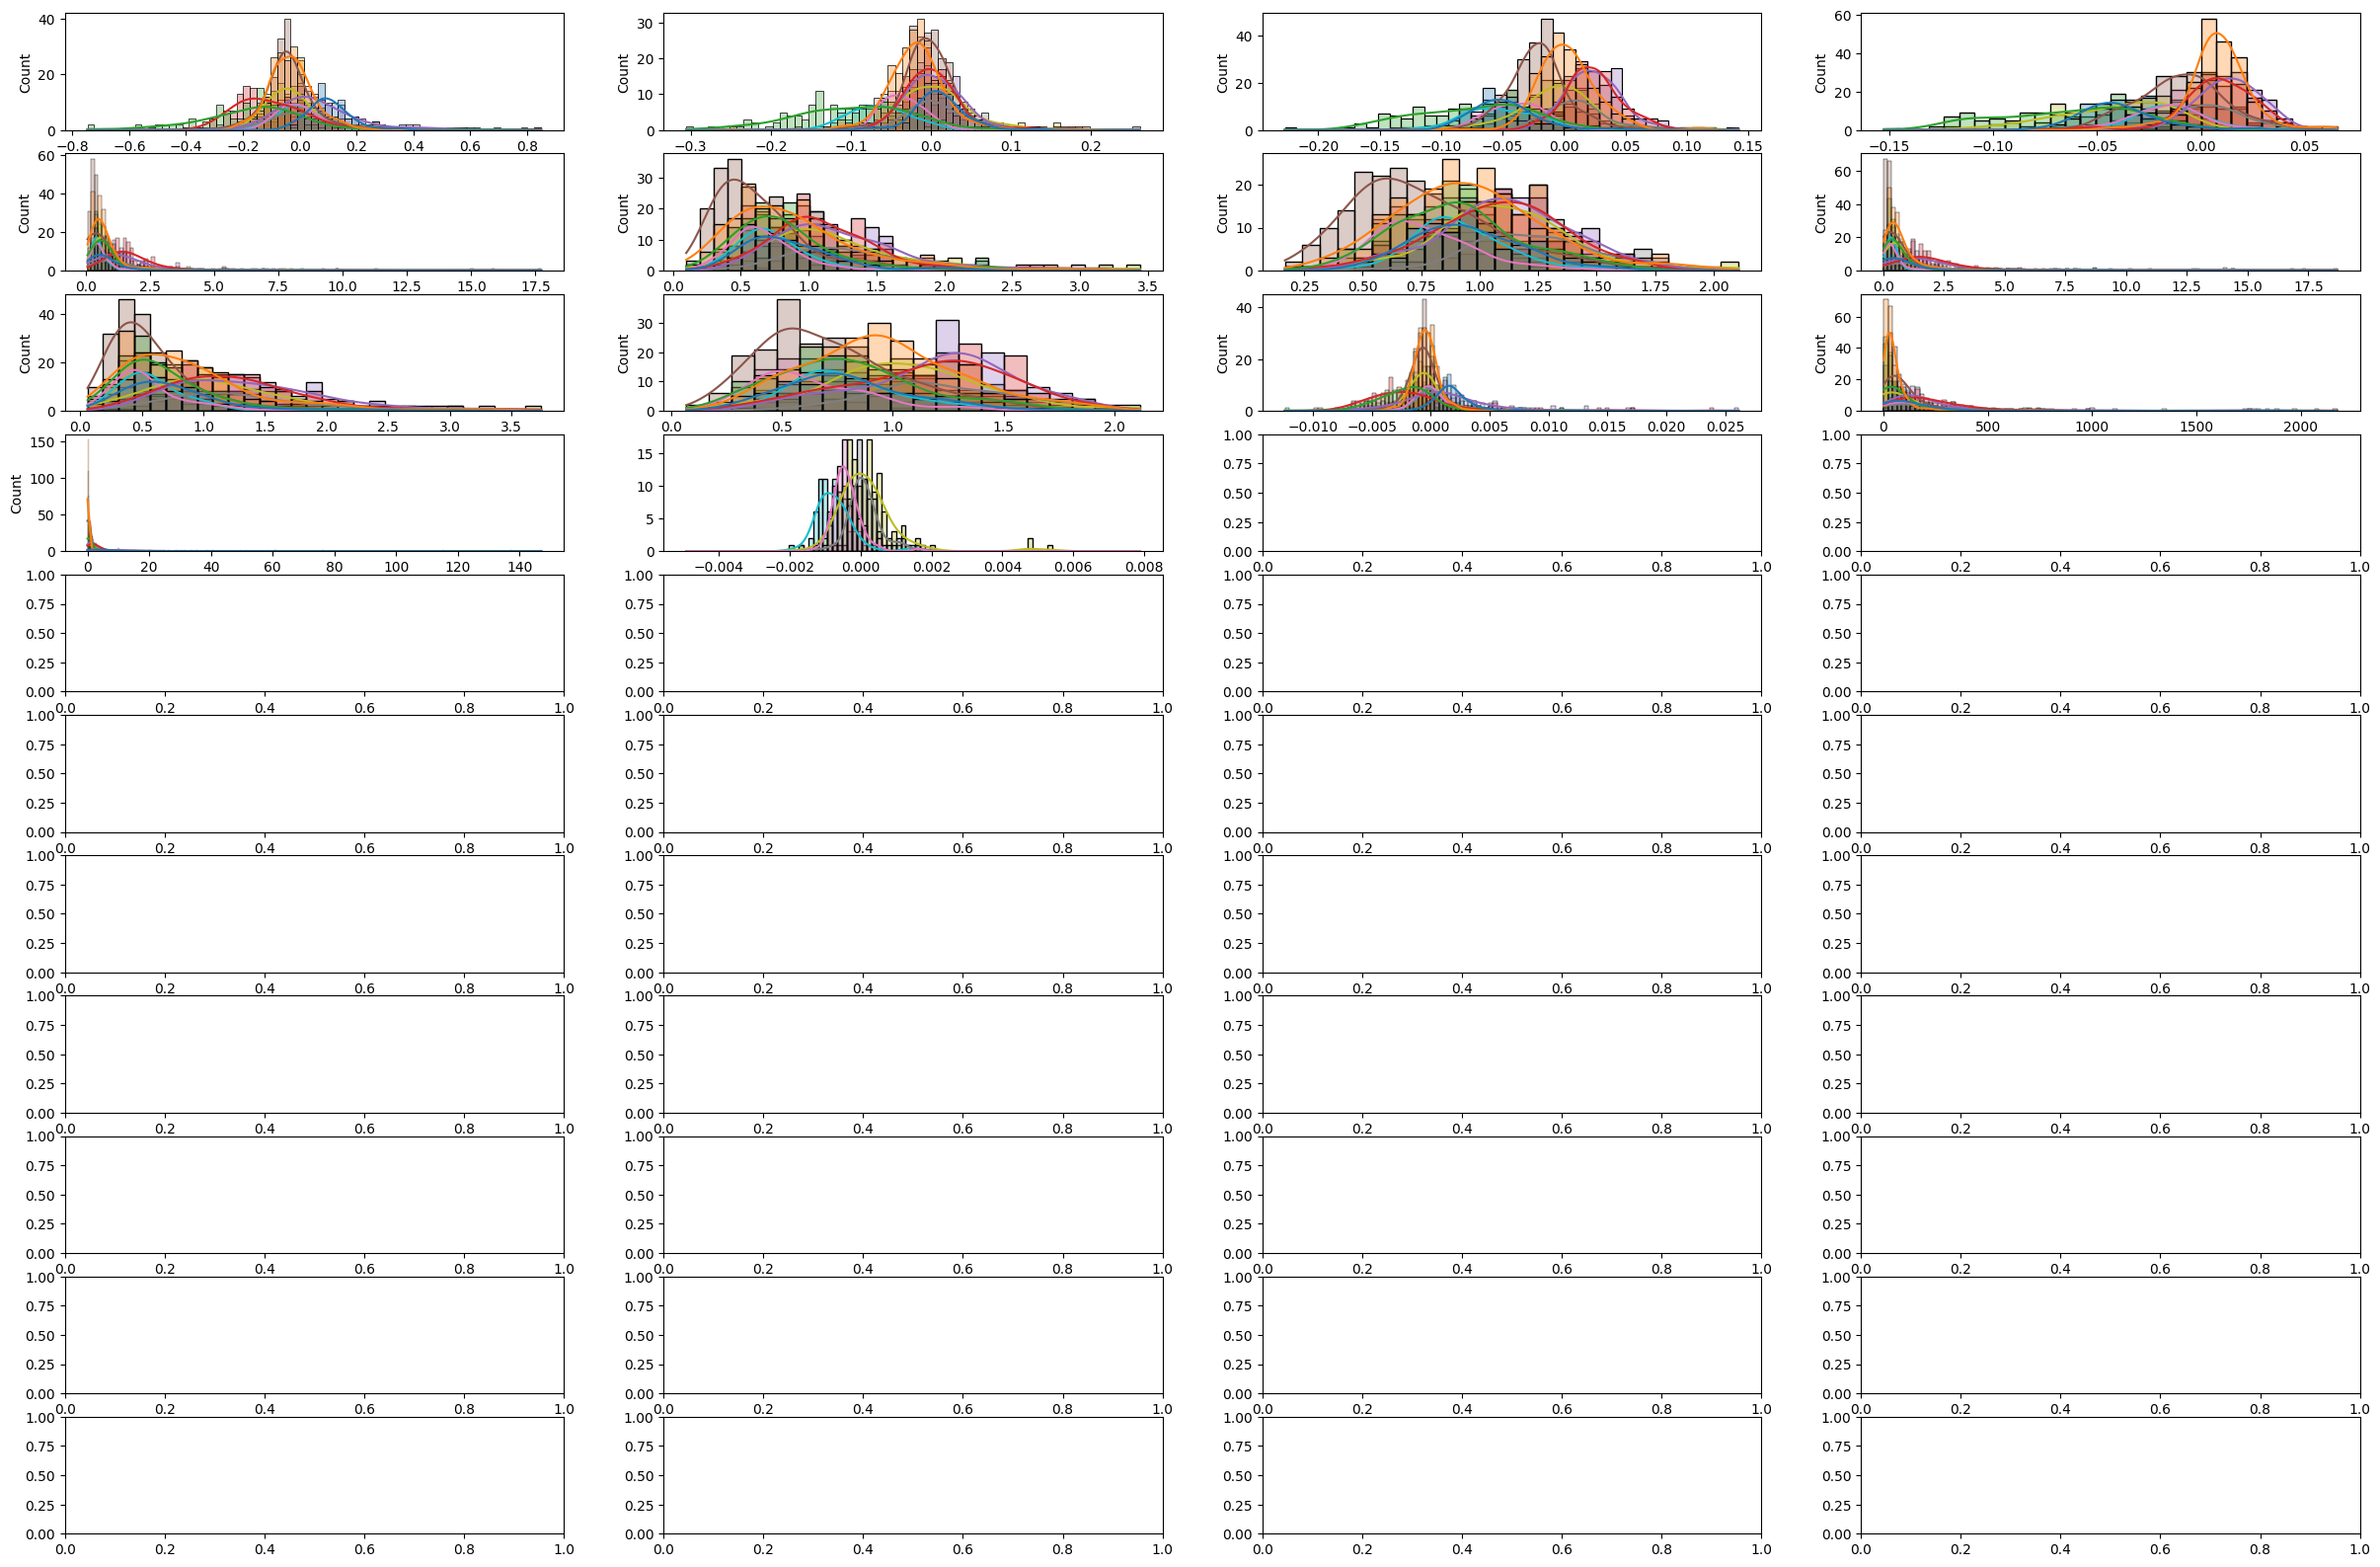

In [11]:
fig, axs = plt.subplots(11, 4, figsize=(30, 20))
axs = [ax for ax_list in axs for ax in ax_list]

for ax, col in tqdm(zip(axs, reg_cols), total=len(reg_cols)):
    sns.histplot(data=df_pumps, x=col, hue="pump_hash", kde=True, alpha=.3, ax=ax, legend=False)

plt.tight_layout()
plt.show()

<h4>Crosssectional normalization</h4>

In [12]:
# standardize these features with crosssectional moments
df_cross_mean = df_features.groupby("pump_hash")[reg_cols].mean().reset_index()
df_cross_std = df_features.groupby("pump_hash")[reg_cols].std().reset_index()

df_features = df_features.merge(
    df_cross_mean, on="pump_hash", how="left", suffixes=["", "_cross_mean"]
)
df_features = df_features.merge(
    df_cross_std, on="pump_hash", how="left", suffixes=["", "_cross_std"]
)

In [13]:
for col in reg_cols:
    df_features[col] = (df_features[col] - df_features[f"{col}_cross_mean"]) / df_features[f"{col}_cross_std"]

In [ ]:
df_pumps: pd.DataFrame = pd.DataFrame()

for i, (pump_hash, df_pump) in enumerate(df_features.groupby("pump_hash")):
    if i >= 10:
        break
    df_pump["pump_hash"] = pump_hash
    df_pumps = pd.concat([df_pumps, df_pump])

df_pumps = df_pumps.reset_index(drop=True)
df_pumps.head()

In [ ]:
fig, axs = plt.subplots(11, 4, figsize=(30, 20))
axs = [ax for ax_list in axs for ax in ax_list]

for ax, col in tqdm(zip(axs, reg_cols), total=len(reg_cols)):
    try:
        sns.histplot(data=df_pumps, x=col, hue="pump_hash", kde=True, alpha=.3, ax=ax, legend=False)
    except:
        print(col)

    for (ticker, pump_time), _ in df_pumps.groupby(["pumped_ticker", "pump_time"]):
        ax.axvline(
            x=df_pumps[
                (df_pumps["pumped_ticker"] == ticker)
                & (df_pumps["pump_time"] == pump_time)
            ][col].iloc[0],
            color="red",
        )

plt.tight_layout()
plt.show()

In [14]:
imbalance_cols = [
    col for col in df_features.columns if "imbalance" in col
]

imbalance_cols

['imbalance_ratio_1d',
 'imbalance_ratio_7d',
 'imbalance_ratio_14d',
 'imbalance_ratio_30d']

<h4>Training</h4>

In [16]:
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import f1_score
from functools import partial

import xgboost as xgb
import optuna
import gc
import numpy as np

In [17]:
reg_cols = reg_cols + imbalance_cols

In [18]:
cutoff_date = "2021-05-01"

df_train = df_features_notna[
    df_features_notna["pump_time"] <= cutoff_date
].copy()

df_test = df_features_notna[
    df_features_notna["pump_time"] > cutoff_date
].copy()

df_train["is_pumped"].value_counts(), df_test["is_pumped"].value_counts()

(is_pumped
 False    7489
 True       60
 Name: count, dtype: int64,
 is_pumped
 False    3996
 True       20
 Name: count, dtype: int64)

In [19]:
df_train = df_train.sort_values(by="pump_time", ascending=True)
df_test = df_test.sort_values(by="pump_time", ascending=True)

In [20]:
dtrain = xgb.DMatrix(data=df_train[reg_cols], label=df_train["is_pumped"])
dtest = xgb.DMatrix(data=df_test[reg_cols], label=df_test["is_pumped"])

In [21]:
df_features_notna.groupby("pump_hash")["pump_hash"].count().mean()

144.5625

In [22]:
def xgboost_objective(
    trial: optuna.Trial, df: pd.DataFrame, reg_cols: List[str], target: str, fold: KFold
):
    xgb_params = {
        "objective": "binary:logistic",
        "eval_metric": ["logloss"],
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 50),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.00001, 0.1),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.00001, 0.1),
        "subsample": trial.suggest_float("subsample", 0.5, 1),
        "gamma": trial.suggest_float("gamma", 0.01, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0, 1),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 150),
    }

    f1_scores = []

    i = 0

    for train_idx, val_idx in fold.split(df[reg_cols], df[target]):
        # split data to train and validation sets
        df_train, df_val = df.iloc[train_idx], df.iloc[val_idx]
        # train on train subset and use validation set to evaluate the model
        dtrain = xgb.DMatrix(df_train[reg_cols], label=df_train[target])
        dval = xgb.DMatrix(df_val[reg_cols], label=df_val[target])

        evals_result = {}

        # Fit the model with early stopping
        model = xgb.train(
            xgb_params,
            dtrain=dtrain,
            evals=[(dtrain, "train"), (dval, "val")],
            num_boost_round=1000,
            early_stopping_rounds=50,
            verbose_eval=False,
            evals_result=evals_result,
        )

        proba = model.predict(dval)   
        y_pred = (proba > 0.5).astype(int) 

        _, f1_minority = f1_score(y_true=df_val[target], y_pred=y_pred, average=None)

        f1_scores.append(f1_minority)

        trial.report(f1_minority, i)

        if trial.should_prune():
            raise optuna.TrialPruned()

        del model, dtrain, dval, y_pred
        _ = gc.collect()

        i += 1

    return np.mean(f1_scores)

In [ ]:
fold = TimeSeriesSplit(n_splits=5)

study_xgboost = optuna.create_study(
    direction="maximize", pruner=optuna.pruners.MedianPruner(n_startup_trials=5)
)

study_xgboost.optimize(
    partial(xgboost_objective, df=df_train, reg_cols=reg_cols, fold=fold, target="is_pumped"),
    n_trials=100,
)

In [24]:
study_xgboost.best_params

{'learning_rate': 0.010210858582261013,
 'max_depth': 30,
 'reg_alpha': 0.04402932321275596,
 'reg_lambda': 0.098669192904681,
 'subsample': 0.8436412183392299,
 'gamma': 0.30872915475770357,
 'colsample_bytree': 0.46732591610878343,
 'scale_pos_weight': 130.9096617833493}

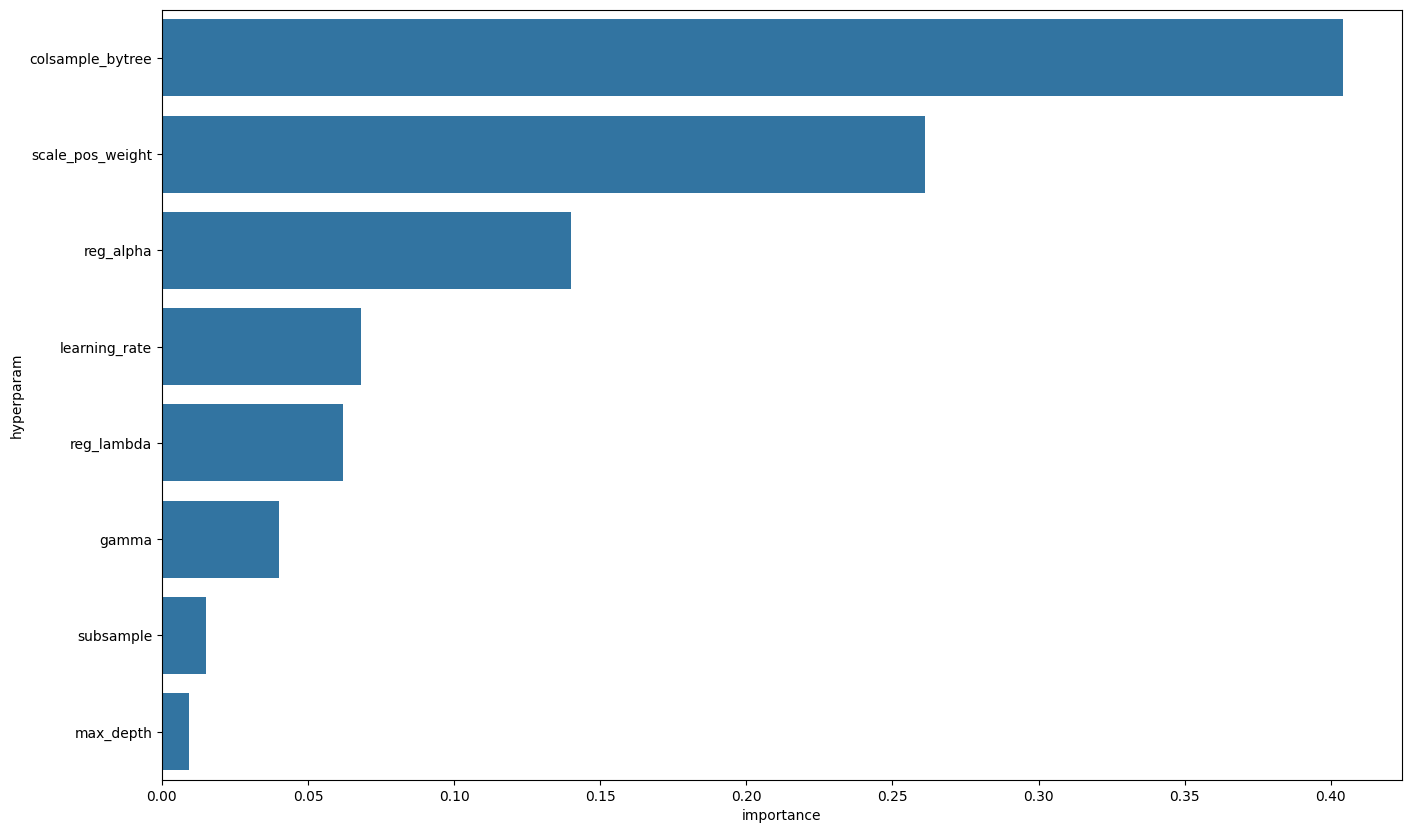

In [25]:
hp_importance: Dict[str, float] = optuna.importance.get_param_importances(
    study_xgboost
)

df_hp_importance = pd.DataFrame({
    "importance": hp_importance.values(),
    "hyperparam": hp_importance.keys()
})

plt.figure(figsize=(16, 10))
sns.barplot(
    data=df_hp_importance, x="importance", y="hyperparam", orient="h"
)

plt.show()

In [26]:
params = {
    "objective": "binary:logistic",
    "eval_metric": ["logloss"],
    "max_depth": 6,
    "learning_rate": 0.05,
    "scale_pos_weight": 10
}

params.update(study_xgboost.best_params)

In [27]:
model = xgb.train(
    params,
    dtrain=dtrain,
    num_boost_round=300,
    # verbose_eval=True,
)

In [28]:
y_proba = model.predict(dtest)
y_pred = y_proba > 0.5

In [29]:
from sklearn.metrics import (
    classification_report, top_k_accuracy_score, ConfusionMatrixDisplay, confusion_matrix
)

print(
    classification_report(y_pred=y_pred, y_true=df_test["is_pumped"], digits=4)
)

              precision    recall  f1-score   support

       False     0.9970    0.9992    0.9981      3996
        True     0.7273    0.4000    0.5161        20

    accuracy                         0.9963      4016
   macro avg     0.8621    0.6996    0.7571      4016
weighted avg     0.9957    0.9963    0.9957      4016



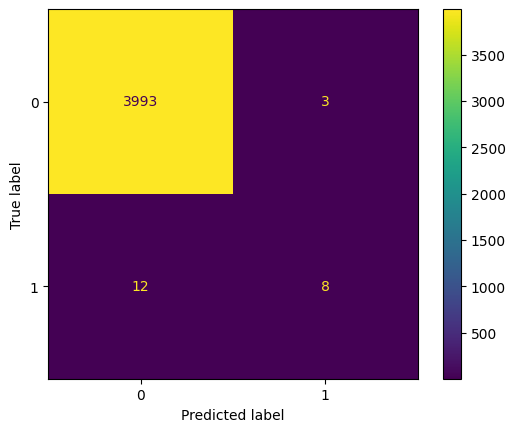

In [30]:
cm = confusion_matrix(y_true=df_test["is_pumped"], y_pred=y_pred)

ConfusionMatrixDisplay(
    confusion_matrix=cm
).plot()
plt.show()

In [ ]:
sns.histplot(y_proba.clip(0, 0.1))
plt.show()

In [ ]:
fi = model.get_score(importance_type="gain")

df_fi = pd.DataFrame({
    "feature": fi.keys(),
    "fi_score": fi.values()
}).sort_values(by="fi_score", ascending=False)

In [ ]:
import seaborn as sns

plt.figure(figsize=(16, 10))
sns.barplot(
    data=df_fi, x="fi_score", y="feature", orient="h"
)

plt.title("Feature importance")
plt.show()